# PAGET differential analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import mnnpy as mnnpy
import numba as numba
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING) 

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

/home/lebrigand/.conda/envs/jupyter/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/lebrigand/.conda/envs/jupyter/lib/python3.7/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: Invalid use of Function(<function norm at 0x7fded742c560>) with argument(s) of type(s): (axis=Literal[int](1), x=array(float32, 2d, A))
 * parameterized
In definition 0:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /home/lebrigand/.conda/envs/jupyter/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /home/lebrigand/.conda/envs/jupyter/lib/python3.7/s

/home/lebrigand/.conda/envs/jupyter/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "adjust_s_variance" was compiled in object mode without forceobj=True, but has lifted loops.

File "../../../../home/lebrigand/.conda/envs/jupyter/lib/python3.7/site-packages/mnnpy/utils.py", line 200:
@jit(float32(float32[:, :], float32[:, :], float32[:], float32[:], float32), nogil=True)
def adjust_s_variance(data1, data2, curcell, curvect, sigma):
^

  state.func_ir.loc))
/home/lebrigand/.conda/envs/jupyter/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../../../../home/lebrigand/.conda/envs/jupyter/lib/python3.7/site-packages/mnnpy/uti

scanpy==1.4.5.2.dev9+g69419872 anndata==0.7.1 umap==0.3.10 numpy==1.17.3 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


In [2]:
sc.settings.set_figure_params(dpi=130)

In [3]:
# soupx 
#wt = sc.read_10x_mtx("/data/10x_data/000-notebooks/10x_paget/wt.soupx.0.25", var_names='gene_symbols', cache=True) 
#wt.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
#wt.obs['sample'] = 'wt'
#wt.obs['name'] = ["{}{}".format(s,'-1-0-wt') for s in list(wt.obs.index)]
#wt.obs_names = wt.obs['name']

In [4]:
# soupx 
#ko = sc.read_10x_mtx("/data/10x_data/000-notebooks/10x_paget/ko.soupx.0.25", var_names='gene_symbols', cache=True) 
#ko.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
#ko.obs['sample'] = 'ko'
#ko.obs['name'] = ["{}{}".format(s,'-1-1-ko') for s in list(ko.obs.index)]
#ko.obs_names = ko.obs['name']

In [5]:
#soupx = wt.concatenate(ko, join='inner')
#soupx.obs_names = soupx.obs['name']

## Remove unwanted cells
#list_of_cell_names = adata_ann.obs.index.tolist()
#soupx = soupx[list_of_cell_names, ]
#soupx.shape

In [6]:
adata_ann = sc.read_h5ad('./output/aggr.ann.h5ad')
adata_raw= sc.read_h5ad('./output/adata.preprocessing.h5ad')

In [7]:
adata_raw.obs['name'] = ["{}{}".format(s,'-wt') for s in list(adata_raw[adata_raw.obs['sample'].isin(['wt']) == True].obs_names)] + ["{}{}".format(s,'-ko') for s in list(adata_raw[adata_raw.obs['sample'].isin(['ko']) == True].obs_names)]
adata_raw.obs_names = adata_raw.obs['name']
adata_raw.obs['cell_type'] = adata_ann.obs['cell_type']

In [8]:
genes_names = adata_raw.var.index.tolist()
keep_genes = [i for i in genes_names if not i.startswith('Gm')]
adata_raw = adata_raw[:,keep_genes]
adata_raw.shape

(7359, 11850)

# Differetial analysis wt-ko

In [9]:
sc.tl.rank_genes_groups(adata_raw, groupby='sample', use_raw=True, key_added='sample_DE_results', n_genes=5000, method= 'wilcoxon')

genes = []
tmp = []
logFC = []
logFC2 = []
pvals_adj = []

genes = genes + adata_raw.uns['sample_DE_results']['names']['ko'].tolist()
logFC = logFC + adata_raw.uns['sample_DE_results']['logfoldchanges']['ko'].tolist()
pvals_adj = pvals_adj + adata_raw.uns['sample_DE_results']['pvals_adj']['ko'].tolist()

genes = genes + adata_raw.uns['sample_DE_results']['names']['wt'].tolist()
tmp = tmp + adata_raw.uns['sample_DE_results']['logfoldchanges']['wt'].tolist()
logFC2 = [i * -1 for i in tmp]
pvals_adj = pvals_adj + adata_raw.uns['sample_DE_results']['pvals_adj']['wt'].tolist()

pvals_adj = np.log10(pvals_adj)
pvals_adj = [i * -1 for i in pvals_adj]

import itertools
c = itertools.chain(logFC, logFC2)

markers = pd.DataFrame(data = {'genes':genes,
                              'logFC':c,
                              'pvals_adj':pvals_adj
                              })


markers.to_csv(path_or_buf = './de.wt.ko.csv', sep = ',', index = False)
markers.head(5)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['sample_DE_results']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


,genes,logFC,pvals_adj
0,Wls,5.322091,inf
1,Hist1h1e,3.675804,240.605180
2,Ramp1,1.580631,240.605180
3,Ncl,1.039796,229.344752
4,Tbc1d4,1.971947,200.230512


# All cell types

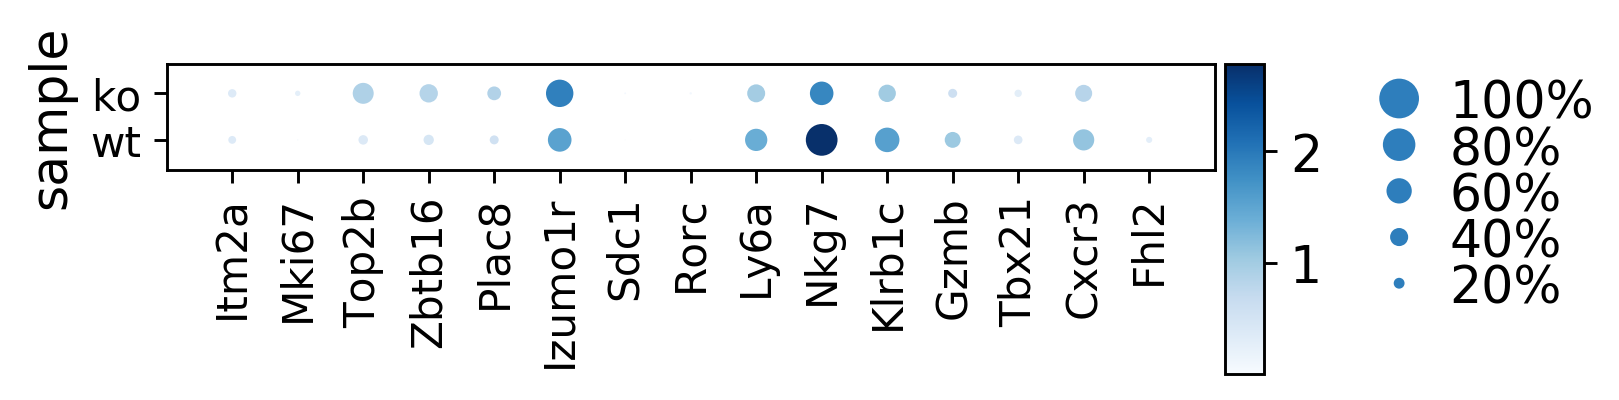

In [10]:
marker_genes = ['Itm2a','Mki67','Top2b','Zbtb16','Plac8','Izumo1r','Sdc1','Rorc','Ly6a','Nkg7','Klrb1c','Gzmb','Tbx21','Cxcr3','Fhl2']


ax = sc.pl.dotplot(adata_raw, marker_genes, dot_max=1, groupby='sample',color_map ="Blues")

# NKT17

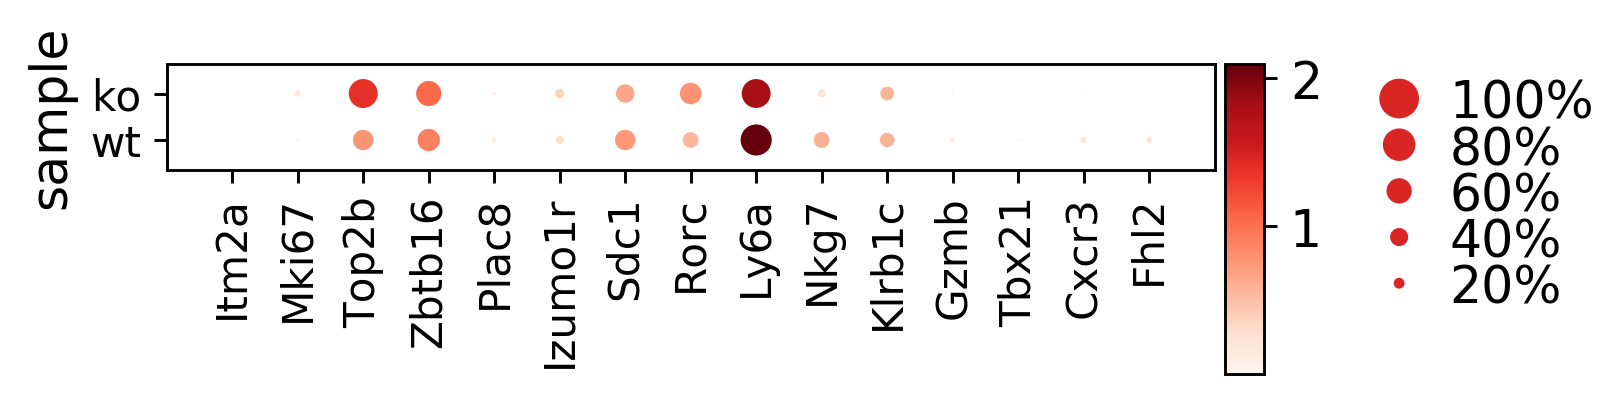

filtered out 1342 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


(433, 10508)

In [11]:
cell_bool = []
for x in adata_raw.obs['cell_type']:
    cell_bool = cell_bool + [x in ['NKT17']]

list_of_cell_names = adata_raw.obs.loc[cell_bool, :].index.tolist()
sub = adata_raw[list_of_cell_names, ]

ax = sc.pl.dotplot(sub, marker_genes, dot_max=1, groupby='sample')

sc.pp.filter_genes(sub, min_cells=3)
sub.shape

In [12]:
sc.tl.rank_genes_groups(sub, groupby='sample', use_raw=True, key_added='sample_DE_results', n_genes=1000, method= 'wilcoxon')

genes = []
tmp = []
logFC = []
logFC2 = []
pvals_adj = []

genes = genes + sub.uns['sample_DE_results']['names']['ko'].tolist()
logFC = logFC + sub.uns['sample_DE_results']['logfoldchanges']['ko'].tolist()
pvals_adj = pvals_adj + sub.uns['sample_DE_results']['pvals_adj']['ko'].tolist()

genes = genes + sub.uns['sample_DE_results']['names']['wt'].tolist()
tmp = tmp + sub.uns['sample_DE_results']['logfoldchanges']['wt'].tolist()
logFC2 = [i * -1 for i in tmp]
pvals_adj = pvals_adj + sub.uns['sample_DE_results']['pvals_adj']['wt'].tolist()

pvals_adj = np.log10(pvals_adj)
pvals_adj = [i * -1 for i in pvals_adj]

import itertools
c = itertools.chain(logFC, logFC2)

markers = pd.DataFrame(data = {'genes':genes,
                              'logFC':c,
                              'pvals_adj':pvals_adj
                              })


markers.to_csv(path_or_buf = './de.wt.ko.nkt17.csv', sep = ',', index = False)
markers.head(5)

ranking genes
    finished: added to `.uns['sample_DE_results']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


,genes,logFC,pvals_adj
0,Wls,2.883560,10.330428
1,Hist1h1e,3.590424,8.462694
2,Smarca5,1.694232,7.904643
3,Srrm2,0.781810,7.458425
4,Tbc1d4,2.077077,7.259901


# NKT0

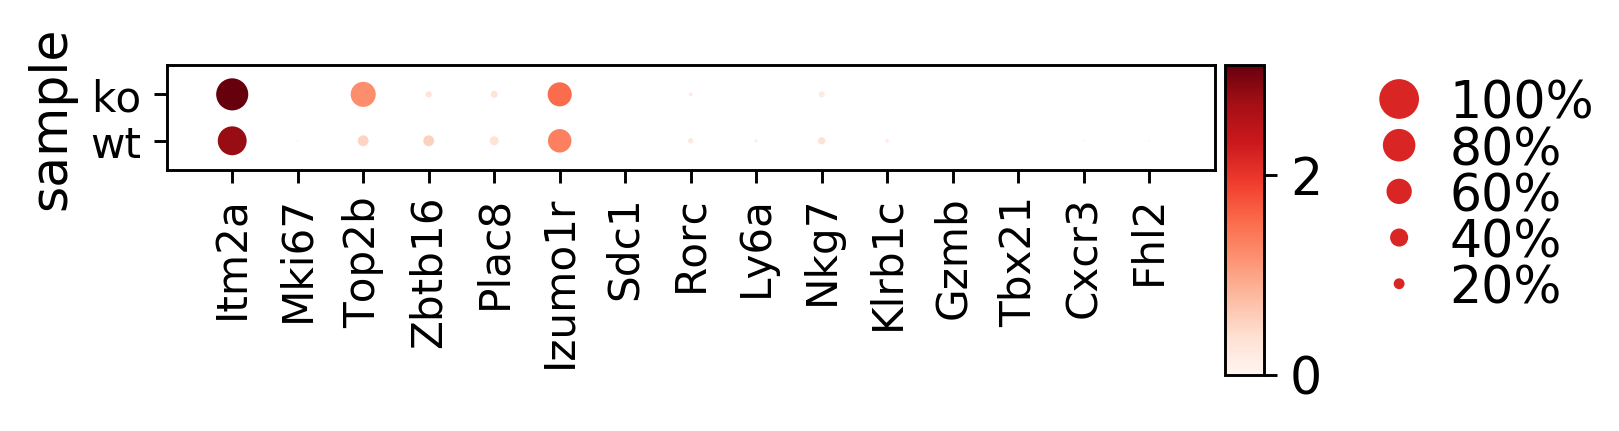

filtered out 4908 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


(56, 6942)

In [13]:
cell_bool = []
for x in adata_raw.obs['cell_type']:
    cell_bool = cell_bool + [x in ['NKT0']]

list_of_cell_names = adata_raw.obs.loc[cell_bool, :].index.tolist()
sub = adata_raw[list_of_cell_names, ]

ax = sc.pl.dotplot(sub, marker_genes, dot_max=1, groupby='sample')

sc.pp.filter_genes(sub, min_cells=3)
sub.shape

In [14]:
sc.tl.rank_genes_groups(sub, groupby='sample', use_raw=True, key_added='sample_DE_results', n_genes=5000, method= 'wilcoxon')

genes = []
tmp = []
logFC = []
logFC2 = []
pvals_adj = []

genes = genes + sub.uns['sample_DE_results']['names']['ko'].tolist()
logFC = logFC + sub.uns['sample_DE_results']['logfoldchanges']['ko'].tolist()
pvals_adj = pvals_adj + sub.uns['sample_DE_results']['pvals_adj']['ko'].tolist()

genes = genes + sub.uns['sample_DE_results']['names']['wt'].tolist()
tmp = tmp + sub.uns['sample_DE_results']['logfoldchanges']['wt'].tolist()
logFC2 = [i * -1 for i in tmp]
pvals_adj = pvals_adj + sub.uns['sample_DE_results']['pvals_adj']['wt'].tolist()

pvals_adj = np.log10(pvals_adj)
pvals_adj = [i * -1 for i in pvals_adj]

import itertools
c = itertools.chain(logFC, logFC2)

markers = pd.DataFrame(data = {'genes':genes,
                              'logFC':c,
                              'pvals_adj':pvals_adj
                              })


markers.to_csv(path_or_buf = './de.wt.ko.nkt0.csv', sep = ',', index = False)
markers.head(5)


ranking genes
    finished: added to `.uns['sample_DE_results']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


,genes,logFC,pvals_adj
0,Myb,2.002860,-0.0
1,Psmd8,1.553381,-0.0
2,Sept7,1.445481,-0.0
3,Anp32e,1.720037,-0.0
4,Glrx,4.649891,-0.0


# NKT2a

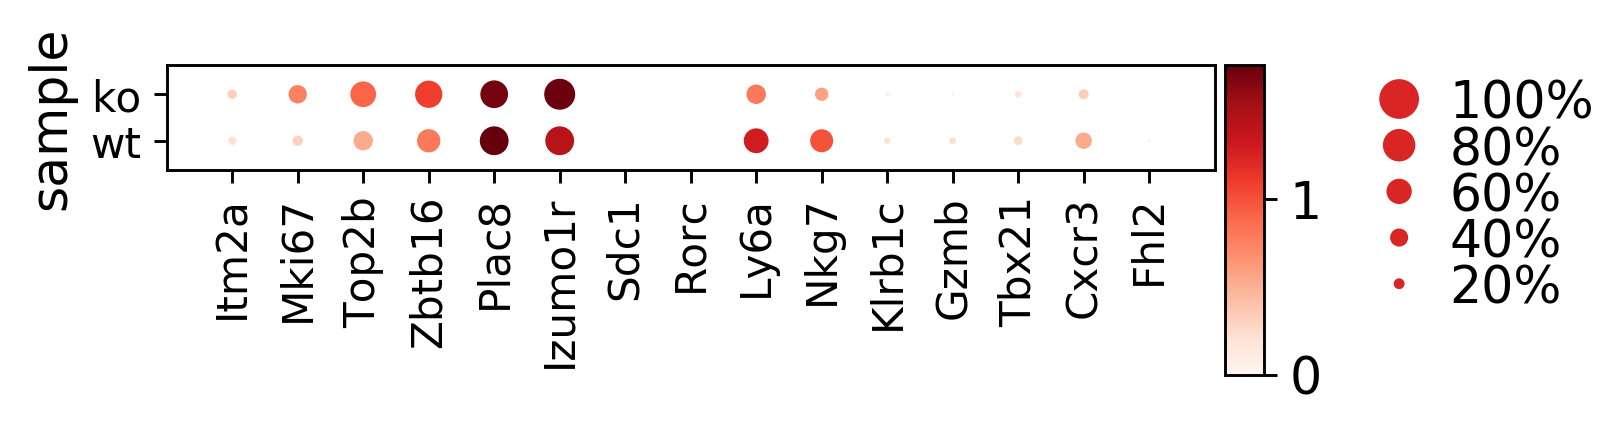

filtered out 1061 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


(478, 10789)

In [15]:
cell_bool = []
for x in adata_raw.obs['cell_type']:
    cell_bool = cell_bool + [x in ['NKT2a']]

list_of_cell_names = adata_raw.obs.loc[cell_bool, :].index.tolist()
sub = adata_raw[list_of_cell_names, ]

ax = sc.pl.dotplot(sub, marker_genes, dot_max=1, groupby='sample')

sc.pp.filter_genes(sub, min_cells=3)
sub.shape

In [16]:
sc.tl.rank_genes_groups(sub, groupby='sample', use_raw=True, key_added='sample_DE_results', n_genes=5000, method= 'wilcoxon')

genes = []
tmp = []
logFC = []
logFC2 = []
pvals_adj = []

genes = genes + sub.uns['sample_DE_results']['names']['ko'].tolist()
logFC = logFC + sub.uns['sample_DE_results']['logfoldchanges']['ko'].tolist()
pvals_adj = pvals_adj + sub.uns['sample_DE_results']['pvals_adj']['ko'].tolist()

genes = genes + sub.uns['sample_DE_results']['names']['wt'].tolist()
tmp = tmp + sub.uns['sample_DE_results']['logfoldchanges']['wt'].tolist()
logFC2 = [i * -1 for i in tmp]
pvals_adj = pvals_adj + sub.uns['sample_DE_results']['pvals_adj']['wt'].tolist()

pvals_adj = np.log10(pvals_adj)
pvals_adj = [i * -1 for i in pvals_adj]

import itertools
c = itertools.chain(logFC, logFC2)

markers = pd.DataFrame(data = {'genes':genes,
                              'logFC':c,
                              'pvals_adj':pvals_adj
                              })


markers.to_csv(path_or_buf = './de.wt.ko.nkt2a.csv', sep = ',', index = False)
markers.head(5)


ranking genes
    finished: added to `.uns['sample_DE_results']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


,genes,logFC,pvals_adj
0,Prrc2c,1.299296,12.969772
1,Ncl,0.852861,12.431569
2,Hist1h1e,3.033674,10.193183
3,Tpr,1.003735,9.530294
4,Hspa4,1.295305,9.376103


# NKT2b

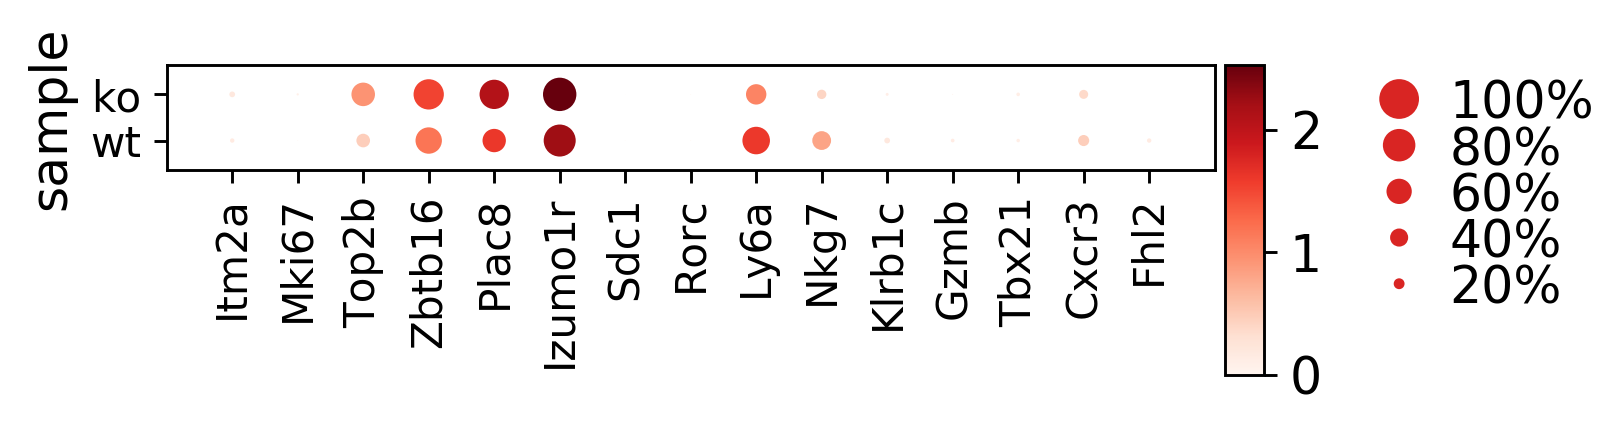

filtered out 603 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


(1060, 11247)

In [17]:
cell_bool = []
for x in adata_raw.obs['cell_type']:
    cell_bool = cell_bool + [x in ['NKT2b']]

list_of_cell_names = adata_raw.obs.loc[cell_bool, :].index.tolist()
sub = adata_raw[list_of_cell_names, ]

ax = sc.pl.dotplot(sub, marker_genes, dot_max=1, groupby='sample')

sc.pp.filter_genes(sub, min_cells=3)
sub.shape

In [18]:
sc.tl.rank_genes_groups(sub, groupby='sample', use_raw=True, key_added='sample_DE_results', n_genes=5000, method= 'wilcoxon')

genes = []
tmp = []
logFC = []
logFC2 = []
pvals_adj = []

genes = genes + sub.uns['sample_DE_results']['names']['ko'].tolist()
logFC = logFC + sub.uns['sample_DE_results']['logfoldchanges']['ko'].tolist()
pvals_adj = pvals_adj + sub.uns['sample_DE_results']['pvals_adj']['ko'].tolist()

genes = genes + sub.uns['sample_DE_results']['names']['wt'].tolist()
tmp = tmp + sub.uns['sample_DE_results']['logfoldchanges']['wt'].tolist()
logFC2 = [i * -1 for i in tmp]
pvals_adj = pvals_adj + sub.uns['sample_DE_results']['pvals_adj']['wt'].tolist()

pvals_adj = np.log10(pvals_adj)
pvals_adj = [i * -1 for i in pvals_adj]

import itertools
c = itertools.chain(logFC, logFC2)

markers = pd.DataFrame(data = {'genes':genes,
                              'logFC':c,
                              'pvals_adj':pvals_adj
                              })


markers.to_csv(path_or_buf = './de.wt.ko.nkt2b.csv', sep = ',', index = False)
markers.head(5)


ranking genes
    finished: added to `.uns['sample_DE_results']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


,genes,logFC,pvals_adj
0,Inpp4b,1.959963,42.583823
1,Hist1h1e,3.681348,38.601948
2,Ptprc,1.320454,34.576147
3,Ncl,0.848254,33.242158
4,Tbc1d4,1.867057,31.383276


# NKT1b

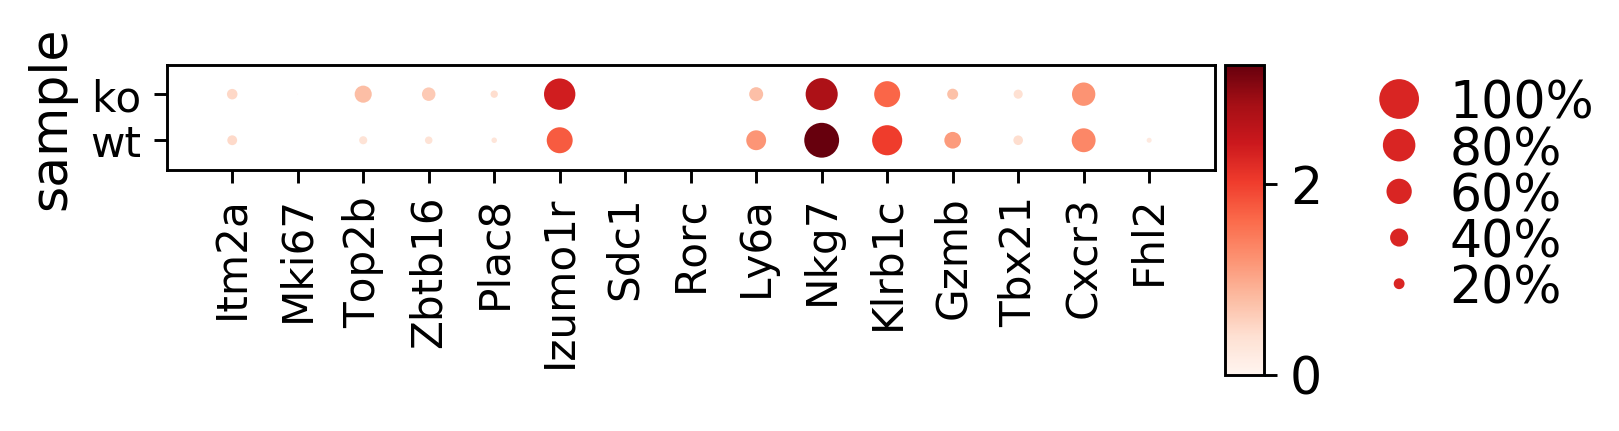

filtered out 639 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


(2832, 11211)

In [19]:
cell_bool = []
for x in adata_raw.obs['cell_type']:
    cell_bool = cell_bool + [x in ['NKT1b']]

list_of_cell_names = adata_raw.obs.loc[cell_bool, :].index.tolist()
sub = adata_raw[list_of_cell_names, ]

ax = sc.pl.dotplot(sub, marker_genes, dot_max=1, groupby='sample')

sc.pp.filter_genes(sub, min_cells=3)
sub.shape

In [20]:
sc.tl.rank_genes_groups(sub, groupby='sample', use_raw=True, key_added='sample_DE_results', n_genes=5000, method= 'wilcoxon')

genes = []
tmp = []
logFC = []
logFC2 = []
pvals_adj = []

genes = genes + sub.uns['sample_DE_results']['names']['ko'].tolist()
logFC = logFC + sub.uns['sample_DE_results']['logfoldchanges']['ko'].tolist()
pvals_adj = pvals_adj + sub.uns['sample_DE_results']['pvals_adj']['ko'].tolist()

genes = genes + sub.uns['sample_DE_results']['names']['wt'].tolist()
tmp = tmp + sub.uns['sample_DE_results']['logfoldchanges']['wt'].tolist()
logFC2 = [i * -1 for i in tmp]
pvals_adj = pvals_adj + sub.uns['sample_DE_results']['pvals_adj']['wt'].tolist()

pvals_adj = np.log10(pvals_adj)
pvals_adj = [i * -1 for i in pvals_adj]

import itertools
c = itertools.chain(logFC, logFC2)

markers = pd.DataFrame(data = {'genes':genes,
                              'logFC':c,
                              'pvals_adj':pvals_adj
                              })


markers.to_csv(path_or_buf = './de.wt.ko.nkt1b.csv', sep = ',', index = False)
markers.head(5)


ranking genes
    finished: added to `.uns['sample_DE_results']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


,genes,logFC,pvals_adj
0,Wls,6.736866,inf
1,Tbc1d4,2.106403,83.682471
2,Ramp1,1.549054,81.620351
3,Ncl,1.022058,78.399498
4,Ptprc,1.022025,65.899604


# NKT1c

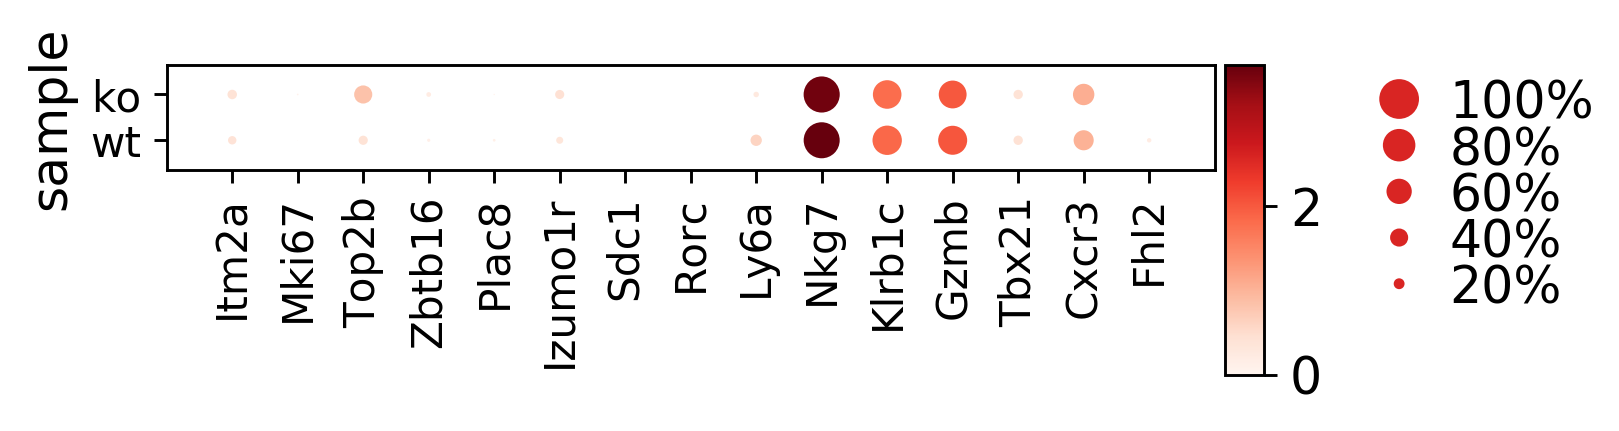

filtered out 1777 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


(714, 10073)

In [21]:
cell_bool = []
for x in adata_raw.obs['cell_type']:
    cell_bool = cell_bool + [x in ['NKT1c']]

list_of_cell_names = adata_raw.obs.loc[cell_bool, :].index.tolist()
sub = adata_raw[list_of_cell_names, ]

ax = sc.pl.dotplot(sub, marker_genes, dot_max=1, groupby='sample')

sc.pp.filter_genes(sub, min_cells=3)
sub.shape

In [22]:
sc.tl.rank_genes_groups(sub, groupby='sample', use_raw=True, key_added='sample_DE_results', n_genes=5000, method= 'wilcoxon')

genes = []
tmp = []
logFC = []
logFC2 = []
pvals_adj = []

genes = genes + sub.uns['sample_DE_results']['names']['ko'].tolist()
logFC = logFC + sub.uns['sample_DE_results']['logfoldchanges']['ko'].tolist()
pvals_adj = pvals_adj + sub.uns['sample_DE_results']['pvals_adj']['ko'].tolist()

genes = genes + sub.uns['sample_DE_results']['names']['wt'].tolist()
tmp = tmp + sub.uns['sample_DE_results']['logfoldchanges']['wt'].tolist()
logFC2 = [i * -1 for i in tmp]
pvals_adj = pvals_adj + sub.uns['sample_DE_results']['pvals_adj']['wt'].tolist()

pvals_adj = np.log10(pvals_adj)
pvals_adj = [i * -1 for i in pvals_adj]

import itertools
c = itertools.chain(logFC, logFC2)

markers = pd.DataFrame(data = {'genes':genes,
                              'logFC':c,
                              'pvals_adj':pvals_adj
                              })


markers.to_csv(path_or_buf = './de.wt.ko.nkt1c.csv', sep = ',', index = False)
markers.head(5)


ranking genes
    finished: added to `.uns['sample_DE_results']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


,genes,logFC,pvals_adj
0,Wls,6.434167,80.269517
1,Ptprc,1.061511,20.785773
2,Ahnak,1.345388,18.309300
3,Tpr,1.237309,16.749556
4,Ncl,0.958867,15.622131


# NKT1d

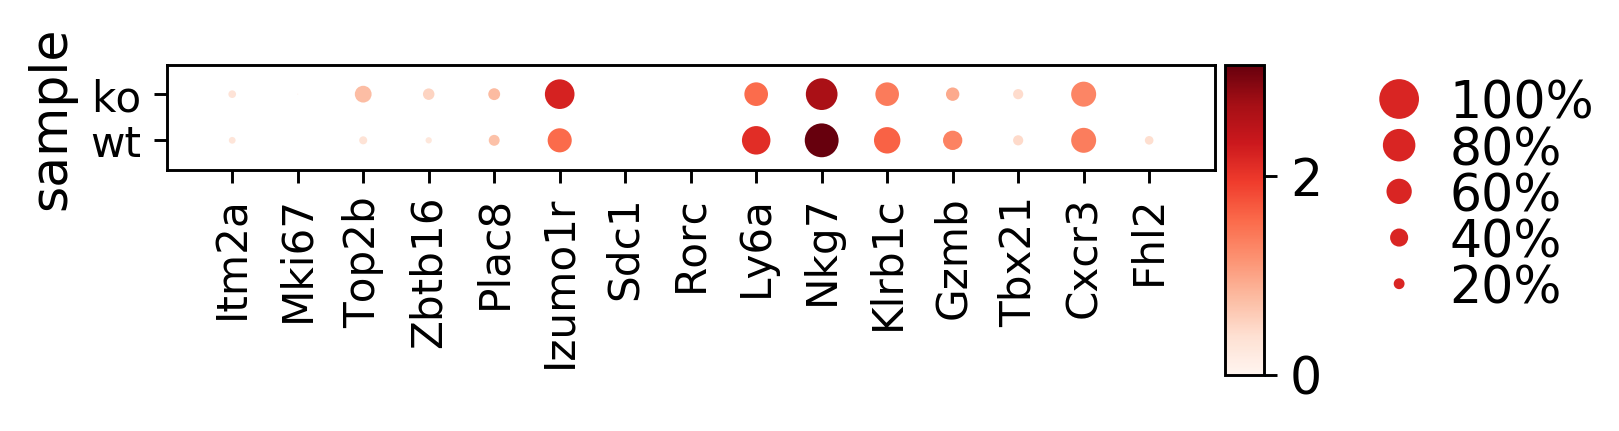

filtered out 1161 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


(1288, 10689)

In [23]:
cell_bool = []
for x in adata_raw.obs['cell_type']:
    cell_bool = cell_bool + [x in ['NKT1d']]

list_of_cell_names = adata_raw.obs.loc[cell_bool, :].index.tolist()
sub = adata_raw[list_of_cell_names, ]

ax = sc.pl.dotplot(sub, marker_genes, dot_max=1, groupby='sample')

sc.pp.filter_genes(sub, min_cells=3)
sub.shape

In [24]:
sc.tl.rank_genes_groups(sub, groupby='sample', use_raw=True, key_added='sample_DE_results', n_genes=5000, method= 'wilcoxon')

genes = []
tmp = []
logFC = []
logFC2 = []
pvals_adj = []

genes = genes + sub.uns['sample_DE_results']['names']['ko'].tolist()
logFC = logFC + sub.uns['sample_DE_results']['logfoldchanges']['ko'].tolist()
pvals_adj = pvals_adj + sub.uns['sample_DE_results']['pvals_adj']['ko'].tolist()

genes = genes + sub.uns['sample_DE_results']['names']['wt'].tolist()
tmp = tmp + sub.uns['sample_DE_results']['logfoldchanges']['wt'].tolist()
logFC2 = [i * -1 for i in tmp]
pvals_adj = pvals_adj + sub.uns['sample_DE_results']['pvals_adj']['wt'].tolist()

pvals_adj = np.log10(pvals_adj)
pvals_adj = [i * -1 for i in pvals_adj]

import itertools
c = itertools.chain(logFC, logFC2)

markers = pd.DataFrame(data = {'genes':genes,
                              'logFC':c,
                              'pvals_adj':pvals_adj
                              })


markers.to_csv(path_or_buf = './de.wt.ko.nkt1d.csv', sep = ',', index = False)
markers.head(5)


ranking genes
    finished: added to `.uns['sample_DE_results']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


,genes,logFC,pvals_adj
0,Wls,5.808018,130.733565
1,Ramp1,1.360102,35.315439
2,Hist1h1e,3.367476,34.363035
3,Samd9l,1.811047,31.075307
4,Tbc1d4,1.895009,30.380676
